In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torch
from torch import optim
from torch import nn
import cv2
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from tqdm import tqdm
import os
import math


c:\Users\普朗克\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import torch
print(torch.__version__)


1.8.2+cu111


In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
data = unpickle('test_batch')
print(data.keys()) # dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data[b'labels'][0] # array([158, 159, 165, ..., 124, 129, 110], dtype=uint8)
#三通道，每个通道为32*32，拉为1为数组

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


3

In [5]:
# d = unpickle("test_batch")
# print(d)
# print(d.keys())
# print(d[b'batch_label'])
# print(d[b'labels'])
# print(d[b'filenames'])


In [6]:

d = unpickle("test_batch")
e = d[b'data']
for i in range(100):
    image = e[i]
    red_image = image[:1024].reshape(32,32)
    green_image = image[1024:2048].reshape(32,32)
    blue_image = image[2048:].reshape(32,32)
    result_img = np.ones((32, 32, 3), dtype=np.uint8)
    result_img[:,:,0] = red_image
    result_img[:,:,1] = green_image
    result_img[:,:,2] = blue_image


In [7]:
# 定义我们的 transforms (1)
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=3),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
class MyDataset(Dataset):
    def __init__(self, trainortest, transforms=train_transform):
        self.trans=transforms
        self.img=[]
        self.label=[]
        if trainortest=="train":
            for i in range(5):
                d=unpickle("data_batch_"+str(i+1))
                data = d[b'data']
                label=d[b'labels']
                for i in range(len(data)):
                    image = data[i]
                    red_image = image[:1024].reshape(32,32)
                    green_image = image[1024:2048].reshape(32,32)
                    blue_image = image[2048:].reshape(32,32)
                    # result_img = np.ones((3,32, 32), dtype=np.uint8)
                    # result_img[0,:,:] = red_image
                    # result_img[1,:,:] = green_image
                    # result_img[2,:,:] = blue_image
                    result_img = np.ones((32,32, 3), dtype=np.uint8)
                    result_img[:,:,0] = red_image
                    result_img[:,:,1] = green_image
                    result_img[:,:,2] = blue_image
                    self.img.append(result_img)
                    self.label.append(label[i])
        elif trainortest=="test":
            d=unpickle("test_batch")
            data = d[b'data']
            label=d[b'labels']
            for i in range(len(data)):
                image = data[i]
                red_image = image[:1024].reshape(32,32)
                green_image = image[1024:2048].reshape(32,32)
                blue_image = image[2048:].reshape(32,32)
                # result_img = np.ones((3,32, 32), dtype=np.uint8)
                # result_img[0,:,:] = red_image
                # result_img[1,:,:] = green_image
                # result_img[2,:,:] = blue_image
                result_img = np.ones((32,32, 3), dtype=np.uint8)
                result_img[:,:,0] = red_image
                result_img[:,:,1] = green_image
                result_img[:,:,2] = blue_image
                
                self.img.append(result_img)
                self.label.append(label[i])

    def __getitem__(self, index):
        img=self.trans(self.img[index])
        return (img, self.label[index])
 
    def __len__(self):
        return len(self.img)
        



In [8]:
def train(train_data, net, optimizer, loss,cur_epoch,num_pro):
    # set model to train mode
    net.train()
    corrects = 0
    if (cur_epoch+1)%num_pro==0:
        for inputs, labels in tqdm(train_loader,position=0):
            # inputs = torch.unsqueeze(inputs, dim=1)  # 得到的tensor应该是四维
            # inputs=inputs.reshape(-1,32*32*3)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # clear the gradients
            optimizer.zero_grad()
            inputs = inputs.float()
            outputs = net(inputs)  # inputs格式要为float
            l = loss(outputs, labels)
            l.backward()
            optimizer.step()

            preds = outputs.argmax(1).detach()
            corrects += (preds == labels.data).sum()
    else:
        for inputs, labels in (train_loader):
            # inputs = torch.unsqueeze(inputs, dim=1)  # 得到的tensor应该是四维
            # inputs=inputs.reshape(-1,32*32*3)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # clear the gradients
            optimizer.zero_grad()
            inputs = inputs.float()
            outputs = net(inputs)  # inputs格式要为float
            l = loss(outputs, labels)
            l.backward()
            optimizer.step()

            preds = outputs.argmax(1).detach()
            corrects += (preds == labels.data).sum()
    torch.save(net,'net.pth')
    return torch.true_divide(corrects, len(train_loader.dataset)),l.item()
    # print(corrects,len(train_loader.dataset))
    return corrects/len(train_loader.dataset)
    # tensor的除法用torch.true_divide

In [9]:
def test(test_loader, net):
    # set model to eval mode
    net.eval()
    corrects = 0

    with torch.no_grad():
        for inputs, labels in (test_loader):
            # inputs = torch.unsqueeze(inputs, dim=1) 
            # inputs=inputs.reshape(-1,32*32*3)
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.float()
            outputs = net(inputs)

            preds = outputs.argmax(1).detach()
            corrects += (preds == labels.data).sum()
    return corrects/len(test_loader.dataset)

In [10]:
train_data=MyDataset('train',transforms=train_transform)
test_data=MyDataset('test',transforms=test_transform)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, drop_last=False,num_workers=0)

In [11]:
'''
残差块
in_channels, out_channels：残差块的输入、输出通道数
对第一层，in out channel都是64，其他层则不同
对每一层，如果in out channel不同， stride是1，其他层则为2
'''
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        # 残差块的第一个卷积
        # 通道数变换in->out，每一层（除第一层外）的第一个block
        # 图片尺寸变换：stride=2时，w-3+2 / 2 + 1 = w/2，w/2 * w/2
        # stride=1时尺寸不变，w-3+2 / 1 + 1 = w
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 残差块的第二个卷积
        # 通道数、图片尺寸均不变
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 残差块的shortcut
        # 如果残差块的输入输出通道数不同，则需要变换通道数及图片尺寸，以和residual部分相加
        # 输出：通道数*2 图片尺寸/2
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            # 通道数相同，无需做变换，在forward中identity = x
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


'''
定义网络结构
'''
class ResNet34(nn.Module):
    def __init__(self, block):
        super(ResNet34, self).__init__()

        # 初始卷积层核池化层
        self.first = nn.Sequential(
            # 卷基层1：3*3kernel，1stride，1padding，outmap：32-3+1*2 / 1 + 1，32*32
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 最大池化，3*3kernel，1stride（保持尺寸），1padding，
            # outmap：32-3+2*1 / 1 + 1，32*32
            nn.MaxPool2d(3, 1, 1)
        )

        # 第一层，通道数不变
        self.layer1 = self.make_layer(block, 64, 64, 3, 1)

        # 第2、3、4层，通道数*2，图片尺寸/2
        self.layer2 = self.make_layer(block, 64, 128, 4, 2)  # 输出16*16
        self.layer3 = self.make_layer(block, 128, 256, 6, 2)  # 输出8*8
        self.layer4 = self.make_layer(block, 256, 512, 3, 2)  # 输出4*4

        self.avg_pool = nn.AvgPool2d(4)  # 输出512*1
        self.fc = nn.Sequential(
                nn.Linear(512, 10),
                nn.Softmax(dim=1)
        )
        

    def make_layer(self, block, in_channels, out_channels, block_num, stride):
        layers = []

        # 每一层的第一个block，通道数可能不同
        layers.append(block(in_channels, out_channels, stride))

        # 每一层的其他block，通道数不变，图片尺寸不变
        for i in range(block_num - 1):
            layers.append(block(out_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.first(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)

        # x.size()[0]: batch size
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

net2 = ResNet34(ResBlock)


In [12]:
class convnet(nn.Module):
    def __init__(self, ):
        super(convnet, self).__init__()     #32*32*3
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
            ) 

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2)
            ) 
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2)
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            )
        self.layer5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            )
        
        self.layer6 =nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = self.layer6(out)

        return out

net1 = convnet()

100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


Train Epoch: 10
train acc: 0.6049000024795532
test acc: 0.5458999872207642


100%|██████████| 196/196 [01:46<00:00,  1.84it/s]


Train Epoch: 20
train acc: 0.7393800020217896
test acc: 0.715999960899353


100%|██████████| 196/196 [01:49<00:00,  1.79it/s]


Train Epoch: 30
train acc: 0.8110399842262268
test acc: 0.7665999531745911


100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


Train Epoch: 40
train acc: 0.8373399972915649
test acc: 0.7865999937057495


100%|██████████| 196/196 [01:41<00:00,  1.93it/s]


Train Epoch: 50
train acc: 0.8530399799346924
test acc: 0.8197000026702881


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Train Epoch: 60
train acc: 0.8661800026893616
test acc: 0.8315999507904053


100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


Train Epoch: 70
train acc: 0.8725999593734741
test acc: 0.8448999524116516


100%|██████████| 196/196 [01:40<00:00,  1.94it/s]


Train Epoch: 80
train acc: 0.8793799877166748
test acc: 0.8522999882698059


100%|██████████| 196/196 [01:40<00:00,  1.94it/s]


Train Epoch: 90
train acc: 0.884939968585968
test acc: 0.8490999937057495


100%|██████████| 196/196 [02:02<00:00,  1.61it/s]


Train Epoch: 100
train acc: 0.8863199949264526
test acc: 0.8574000000953674


100%|██████████| 196/196 [01:47<00:00,  1.83it/s]


Train Epoch: 110
train acc: 0.8941599726676941
test acc: 0.861299991607666


100%|██████████| 196/196 [01:40<00:00,  1.95it/s]


Train Epoch: 120
train acc: 0.8946799635887146
test acc: 0.8600999712944031


100%|██████████| 196/196 [01:41<00:00,  1.94it/s]


Train Epoch: 130
train acc: 0.900439977645874
test acc: 0.8500999808311462


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Train Epoch: 140
train acc: 0.8982599973678589
test acc: 0.8542999625205994


100%|██████████| 196/196 [01:56<00:00,  1.69it/s]


Train Epoch: 150
train acc: 0.9036799669265747
test acc: 0.8649999499320984


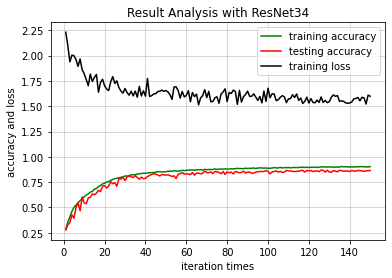

the max accure of epoch: 125 0.8696


In [13]:

if torch.cuda.is_available():
    device = "cuda:0"   # gpu or cpu
    net = net2.cuda()
else:
    device="cpu"


optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0001)

loss = nn.CrossEntropyLoss()
train_acc2=[]
test_acc2=[]
train_loss2=[]
epoch=150
num_pro=10  #展示次数
for i in (range(epoch)):
    temp_acc,temp_loss=train(train_loader, net, optimizer, loss,i,num_pro)
    train_acc2.append(temp_acc)
    train_loss2.append(temp_loss)
    test_acc2.append( test(test_loader, net))
    if (i+1)%num_pro==0:
        print("Train Epoch:",i+1)
        print("train acc:", float(train_acc2[i]))
        print("test acc:", float(test_acc2[i]))
for i in range(len(train_acc2)):
    train_acc2[i]=train_acc2[i].data.cpu().numpy()
    test_acc2[i]=test_acc2[i].data.cpu().numpy()
plt.title('Result Analysis with ResNet34')
plt.plot([i+1 for i in range(len(train_acc2))], train_acc2, color='green', label='training accuracy')
plt.plot([i+1 for i in range(len(test_acc2))], test_acc2, color='red', label='testing accuracy')
plt.plot([i+1 for i in range(len(train_loss2))], train_loss2, color='black', label='training loss')
plt.legend() # 显示图例
plt.grid(True, alpha=0.5, linewidth = 1)
plt.xlabel('iteration times')
plt.ylabel('accuracy and loss')
plt.show()
print("the max accure of epoch:",np.argmax(test_acc2),np.max(test_acc2))

卷积神经网络

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Train Epoch: 10
train acc: 0.6311799883842468
test acc: 0.6331999897956848


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


Train Epoch: 20
train acc: 0.6867799758911133
test acc: 0.7037000060081482


100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


Train Epoch: 30
train acc: 0.7147200107574463
test acc: 0.7228999733924866


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


Train Epoch: 40
train acc: 0.7296800017356873
test acc: 0.7292999625205994


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


Train Epoch: 50
train acc: 0.745419979095459
test acc: 0.753600001335144


100%|██████████| 196/196 [00:15<00:00, 12.39it/s]


Train Epoch: 60
train acc: 0.751479983329773
test acc: 0.7574999928474426


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


Train Epoch: 70
train acc: 0.7615000009536743
test acc: 0.7548999786376953


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


Train Epoch: 80
train acc: 0.7669199705123901
test acc: 0.765999972820282


100%|██████████| 196/196 [01:01<00:00,  3.19it/s]


Train Epoch: 90
train acc: 0.7705399990081787
test acc: 0.7694999575614929


100%|██████████| 196/196 [00:52<00:00,  3.70it/s]


Train Epoch: 100
train acc: 0.7765199542045593
test acc: 0.7809999585151672


100%|██████████| 196/196 [00:52<00:00,  3.77it/s]


Train Epoch: 110
train acc: 0.7798799872398376
test acc: 0.7735999822616577


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


Train Epoch: 120
train acc: 0.7834599614143372
test acc: 0.7798999547958374


100%|██████████| 196/196 [00:51<00:00,  3.79it/s]


Train Epoch: 130
train acc: 0.7852399945259094
test acc: 0.786799967288971


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


Train Epoch: 140
train acc: 0.7895599603652954
test acc: 0.7760999798774719


100%|██████████| 196/196 [00:51<00:00,  3.80it/s]


Train Epoch: 150
train acc: 0.7912399768829346
test acc: 0.7888999581336975


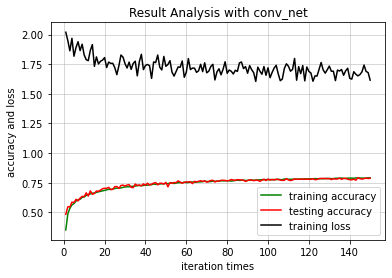

the max accure of epoch: 143 0.793


In [14]:
if torch.cuda.is_available():
    device = "cuda:0"   # gpu or cpu
    net = net1.cuda()
else:
    device="cpu"

optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0001)

loss = nn.CrossEntropyLoss()
train_acc=[]
test_acc=[]
train_loss=[]
epoch=150
num_pro=10  #展示次数
for i in (range(epoch)):
    temp_acc,temp_loss=train(train_loader, net, optimizer, loss,i,num_pro)
    train_acc.append(temp_acc)
    train_loss.append(temp_loss)
    test_acc.append( test(test_loader, net))
    if (i+1)%num_pro==0:
        print("Train Epoch:",i+1)
        print("train acc:", float(train_acc[i]))
        print("test acc:", float(test_acc[i]))
for i in range(len(train_acc)):
    train_acc[i]=train_acc[i].data.cpu().numpy()
    test_acc[i]=test_acc[i].data.cpu().numpy()
plt.title('Result Analysis with conv_net')
plt.plot([i+1 for i in range(len(train_acc))], train_acc, color='green', label='training accuracy')
plt.plot([i+1 for i in range(len(test_acc))], test_acc, color='red', label='testing accuracy')
plt.plot([i+1 for i in range(len(train_loss))], train_loss, color='black', label='training loss')
plt.legend() # 显示图例
plt.grid(True, alpha=0.5, linewidth = 1)
plt.xlabel('iteration times')
plt.ylabel('accuracy and loss')
plt.show()
print("the max accure of epoch:",np.argmax(test_acc),np.max(test_acc))

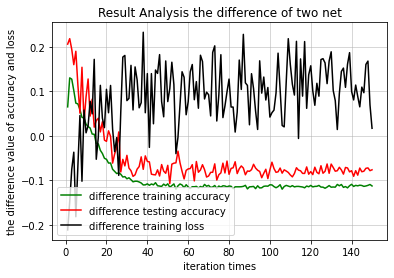

the max accure with conv of epoch: 143 0.793
the max accure with ResNet34 of epoch: 125 0.8696


In [15]:
dif_train_acc=[x-y for x,y in zip(train_acc,train_acc2) ]
dif_test_acc=[x-y for x,y in zip(test_acc,test_acc2) ]
dif_train_loss=[x-y for x,y in zip(train_loss,train_loss2) ]
plt.title('Result Analysis the difference of two net')
plt.plot([i+1 for i in range(len(dif_train_acc))], dif_train_acc, color='green', label='difference training accuracy')
plt.plot([i+1 for i in range(len(dif_test_acc))], dif_test_acc, color='red', label='difference testing accuracy')
plt.plot([i+1 for i in range(len(dif_train_loss))], dif_train_loss, color='black', label='difference training loss')
plt.legend() # 显示图例
plt.grid(True, alpha=0.5, linewidth = 1)
plt.xlabel('iteration times')
plt.ylabel('the difference value of accuracy and loss')
plt.show()
print("the max accure with conv of epoch:",np.argmax(test_acc),np.max(test_acc))
print("the max accure with ResNet34 of epoch:",np.argmax(test_acc2),np.max(test_acc2))

训练次数还不够多，但是正确率趋于稳定，用了resnet的效果明显好一些